#### **License**

```
Copyright 2021 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```

#### **Description**

This colab accompanies the paper 'Human-centred mechanism design with democratic AI research' Nature Human Behavior 2022 by Koster, Balaguer et al.

It provides functions to load the data from the experiments, and reproduces figures 1C, 2, 3A and 3C.

To try this code yourself, press: `Runtime` > `Run all`.

#### **Imports**

In [1]:
import enum
import itertools
import tempfile
from typing import Tuple, Optional, List

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns


#### **Functions**

In [ ]:
#@markdown `load_file`
def load_file(
    filename: str,
    column_names: Optional[List[str]] = None,
    dtype: Optional[np.dtype] = None) -> pd.DataFrame:
  """Loads a CSV file from Google Cloud."""
  with tempfile.NamedTemporaryFile() as f:
    !gsutil cp {filename} {f.name}
    with open(f.name, 'rb') as csv_file:
      data = pd.read_csv(csv_file, names=column_names, dtype=dtype)
    return data

In [ ]:
#@markdown `get_beach_matrix`
def get_beach_matrix(df: pd.DataFrame) -> Tuple[np.ndarray, int, int]:
  """Gets beach values.

  Args:
    df: pandas dataframe containing distributions for a given tail endowment.
  Returns:
    A tuple `(beach_matrix, max_head, max_tail)` where:
    `beach_matrix` is the 2d array with values of the beach plot.
    `max_head` is the sum of endowments by all head players.
    `max_tail` is the sum of endowments by all tail players.
  """
  head_contribution = np.int64(df['contribution_0'])
  max_head = np.max(head_contribution)
  tail_contribution = np.int64(
      df['contribution_1'] + df['contribution_2'] + df['contribution_3'])
  max_tail = np.max(tail_contribution)
  metric = df['distribution_0']
  beach_matrix = np.zeros([max_head + 1, max_tail + 1])
  for head_value, tail_value in (
      itertools.product(range(max_head + 1), range(max_tail + 1))):
    head_mask = head_value == head_contribution
    tail_mask = tail_value == tail_contribution
    mask = head_mask & tail_mask
    beach_matrix[head_value, tail_value] = metric[mask].mean()
  return beach_matrix, max_head, max_tail


In [ ]:
#@markdown `beach_plot`
def beach_plot(
    *,
    ax: plt.Axes,
    beach_matrix: np.ndarray,
    cmap: str = 'viridis',
    levels: int = 10,
    linewidths: float = 1.5,
    max_head: int,
    max_tail: int,
    vmax: Optional[float] = 1.,
    vmin: Optional[float] = 0.,
) -> matplotlib.image.AxesImage:
  """Plots the contour "beachplot".

  Args:
    ax: matplotlib axes where to plot.
    beach_matrix: 2d array with values of the beach plot.
    cmap: colormap (as supported by matplotlib).
    levels: number of levels of the contour plot.
    linewidths: width of contour lines.
    max_head: sum of endowments by all head players.
    max_tail: sum of endowments by all tail players.
    vmax: maximum value of contour plot.
    vmin: minimum value of contour plot.
  Returns:
    A matplotlib axes image object.
  """
  head_ticks = tuple(range(max_head + 1))
  tail_ticks = tuple(range(max_tail + 1))
  ax.contour(
      tail_ticks,
      head_ticks,
      beach_matrix,
      levels=levels,
      linewidths=linewidths,
      colors='k',
      vmin=vmin,
      vmax=vmax)
  return ax.contourf(
      tail_ticks,
      head_ticks,
      beach_matrix,
      levels=levels,
      cmap=cmap,
      vmin=vmin,
      vmax=vmax)
  


In [ ]:
#@markdown `make_beach_figure`
def make_beach_figure(df: pd.DataFrame) -> plt.Figure:
  """Makes a figure with many subplots, one per tail endowment type.

  Args:
    df: pandas dataframe containing mechanism distributions.
  Returns:
    Matplotlib pyplot figure object.
  """
  # Find number of unique endowments.
  fig, (axs,) = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=[10, 2])
  for idx, (ax, tail_endowment) in enumerate(zip(axs, (2, 4, 6, 8, 10))):
    endowment_df = df[df['endowment_1'] == tail_endowment]
    beach_matrix, max_head, max_tail = get_beach_matrix(endowment_df)
    beach_plot(
        beach_matrix=beach_matrix,
        ax=ax,
        max_head=max_head,
        max_tail=max_tail)
    ax.set_xlabel('Tail players')
    if idx == 0:
      ax.set_ylabel('Head player')
    else:
      ax.set_yticks([])
    ax.set_title(f'Tail endowment {tail_endowment}')
  return fig

#### **Load data**

In [ ]:
#@markdown This cell contains an exhaustive description of the data.
#@markdown Select `Show code` to see it.

""" Description of data.

data_exp1: Data from 'Experiment 1' in the paper, shown in Fig. 1c.
  Shape: (41860, 12)
  Columns:
    participant_id: unique participant identifier (1.0-10500.0), float.
    player_id: id of player in game, 0 is the head player (0-3), int.
    contribution: How many coins the player contributed (0-10), int.
    endowment: How many coins the player was endowed with (2, 4, 10), int.
    session: Number of game-session in the task. 0 is the tutorial game. 3
      is the bonus round (or 5, if there were 5 session), int.
    timestep: Timestep in game (0-9), int.
    endowcond: Endowment of the tail players (2, 4, 10), int.
    mechanism_code: Mechanism to be evaluated (1, 2, 3, 4), int.
    baseline: Which mechanism was the baseline baseline in this game (3, 2),
      int.
    head: Whether the player is the head player (True, False), bool.
    rel_contribution: Relative contribution: contribution / endowment (0 to
      1.), float.
    payout: Payouts received from mechanism this step (0.0-31.736),
      float.
data_exp2: Data from 'Experiment 2' in the paper, shown in Fig. 3c.
  Shape: (140700, 13)
  Columns:
    player_id: id of player in game, 0 is the head player (0-3), int.
    contribution: How many coins the player contributed (0-10), int.
    endowment: How many coins the player was endowed with (2, 4, 6, 8, 10),
      int.
    session: Number of game-session in the task. 0 is the tutorial game. 3
      is the bonus round, int.
    timestep: Timestep in game (0-9), int.
    mechanism_code: Mechanism to be evaluated (1, 2, 3, 4, 6), int.
    participant_id: unique participant identifier (1.0-60736.0), float.
    endowcond: Endowment of the tail players (2, 4, 6, 8, 10), int.
    baseline: Which mechanism was the baseline baseline in this game (1, 2,
      3, 6), int.
    head: Whether the player is the head player (True, False), bool.
    rel_contribution: Relative contribution: contribution / endowment (0 to
      1.), float.
    vote: 1 if vote was for agent, 0 for baseline, nan if missing, int.
    payout: Payouts received from mechanism this step (0.0-38.069),
      float.
players_data2: is a playerwise transformation of players_data2, shown in
  Figure 2.
  Shape: (4020, 8)
  Columns:
    endowcond: Endowment of the tail players (2, 4, 6, 8, 10), int.
    player_id: id of player in game, 0 is the head player (0-3), int.
    baseline: Which mechanism was the baseline baseline in this game (1, 2,
      3, 6), int.
    real: Whether >99% of all trials were real responses, bool.
    endowment: How many coins the player was endowed with (2, 4, 6, 8, 10),
      int.
    vote_cast: Whether a vote was cast or if the vote is missing, bool.
    participant_id: unique participant identifier (0.0001-6.0736), float.
    vote_for_agent: Whether the vote was cast for agent, or the
      baseline/mising, bool.
players_data4: is the experiment with the human player as mechanism.
  Shape: (11696, 13)
  Columns:
    participant_id: unique participant identifier (1.0-10244.0), float.
    player_id: id of player in game, 0 is the head player (0-3), int.
    contribution: How many coins the player contributed (0-10), int.
    endowment: How many coins the player was endowed with (4, 10), int.
    session: Number of game-session in the task. 0 is the tutorial game. 3
      is the bonus round, int.
    timestep: Timestep in game (0-9), int.
    endowcond: Endowment of the tail players (4), int.
    mechanism_code: Mechanism to be evaluated (1, 4, 7), int.
    baseline: Which mechanism was the baseline baseline in this game (7),
      int.
    head: Whether the player is the head player (True, False), bool.
    rel_contribution: Relative contribution: contribution / endowment (0 to
      1.), float.
    vote: 1 if vote was for agent, 0 for baseline, nan if missing, int.
    payout: Payouts received from mechanism this step (0.0-32), float.
data_exp4: is a playerwise transformation of players_data4.
  Shape: (344, 8)
  Columns:
    endowcond: Endowment of the tail players (4), int.
    player_id: id of player in game, 0 is the head player (0-3), int.
    baseline: Which mechanism was the baseline baseline in this game (7),
      int
    real: Whether >99% of all trials were real responses, bool.
    endowment: How many coins the player was endowed with (4, 10), int
    vote_cast: Whether a vote was cast or if the vote is missing, bool.
    participant_id: unique participant identifier (0.0001-1.0244), float.
    vote_for_agent: Whether the vote was cast for agent, or the
      baseline/mising, bool.
"""

In [ ]:
#@markdown Experiment data.
exp1_name_list = [
    'participant_id',
    'player_id',
    'contribution',
    'endowment',
    'session',
    'timestep',
    'endowcond',
    'mechanism_code',
    'baseline',
    'head',
    'rel_contribution',
    'payout',
]
exp2_name_list = [
    'player_id',
    'contribution',
    'endowment',
    'session',
    'timestep',
    'mechanism_code',
    'participant_id',
    'endowcond',
    'baseline',
    'head',
    'rel_contribution',
    'vote',
    'payout',
]
exp4_name_list = [
    'participant_id',
    'player_id',
    'contribution',
    'endowment',
    'session',
    'timestep',
    'endowcond',
    'mechanism_code',
    'baseline',
    'head',
    'rel_contribution',
    'vote',
    'payout',
]
exp_type_list = {
    'player_id': np.float32,
    'contribution': np.int32,
    'endowment': np.int32,
    'session': np.int32,
    'timestep': np.int32,
    'mechanism_code': np.int32,
    'participant_id': np.float32,
    'endowcond': np.int32,
    'baseline': np.int32,
    'head': np.bool8,
    'rel_contribution': np.float32,
    'vote': np.float32,
    'payout': np.float32,
}
players_name_list = [
    'endowcond',
    'player_id',
    'baseline',
    'real',
    'endowment',
    'vote_cast',
    'participant_id',
    'vote_for_agent',
]
players_types= {
    'endowcond': np.float32,
    'player_id': np.int32,
    'baseline': np.int32,
    'real': np.bool8,
    'endowment': np.int32,
    'vote_cast': np.bool8,
    'participant_id': np.float32,
    'vote_for_agent': np.int32,
}
data_exp1 = load_file('gs://dm_hcmd_dai/data_exp1.csv',
                      column_names=exp1_name_list, dtype=exp_type_list)
data_exp2 = load_file('gs://dm_hcmd_dai/data_exp2.csv',
                      column_names=exp2_name_list, dtype=exp_type_list)
players_exp2 = load_file('gs://dm_hcmd_dai/players_exp2.csv',
                         column_names=players_name_list, dtype=players_types)
data_exp4 = load_file('gs://dm_hcmd_dai/data_exp4.csv',
                      column_names=exp4_name_list, dtype=exp_type_list)
players_exp4 = load_file('gs://dm_hcmd_dai/players_exp4.csv',
                         column_names=players_name_list, dtype=players_types)


In [ ]:
#@markdown Beachplot data.
hcrm_beach = load_file('gs://dm_hcmd_dai/beachplot_hcrm.csv')
liberal_egalitarian_beach = load_file('gs://dm_hcmd_dai/beachplot_liberal_egalitarian.csv')
libertarian_beach = load_file('gs://dm_hcmd_dai/beachplot_libertarian.csv')
rational_beach = load_file('gs://dm_hcmd_dai/beachplot_rational_mechanism.csv')


#### **Figure 1C**



> *Average relative contributions (as a fraction of endowment) over 10 rounds (x-axis) in Exp.1 for three different initial endowment conditions. Under strict egalitarian redistribution, tail player (triangles) contributions are higher when initial endowments are lower, but head player (circles) contributions do not differ. Under libertarian, head player contributions increase with equality, but tail player contributions remain constant. Tail player contributions increase strongly with endowment under liberal egalitarian.*



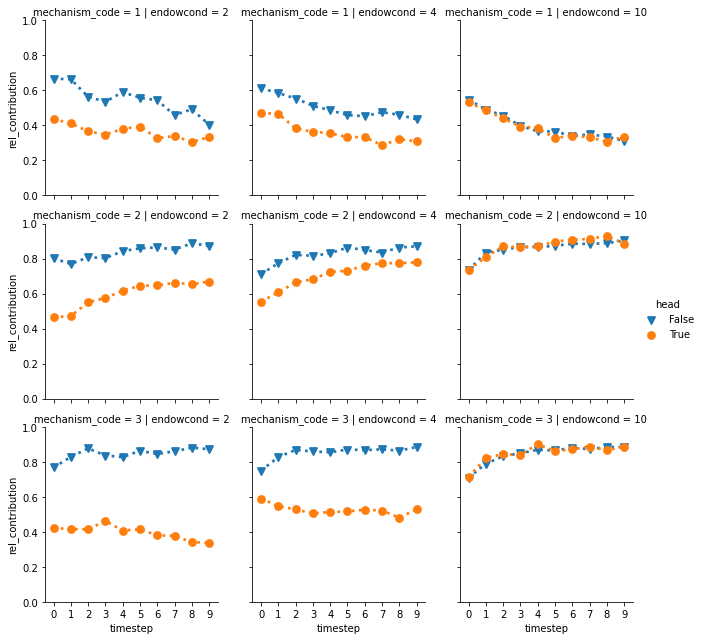

In [ ]:
#@title
#@markdown
facet_grid = sns.catplot(
    data=data_exp1[data_exp1.mechanism_code < 4],
    x='timestep',
    y='rel_contribution',
    hue='head',
    col='endowcond',
    row='mechanism_code',
    kind='point',
    ci=None,
    linestyles=['dotted', 'dotted'],
    markers=['v', 'o'],
    height=3,
    aspect=1,
)
_ = facet_grid.set(ylim=(0, 1))

#### **Figure 2**



> *Vote share for the HCRM against the three canonical baselines (leftmost columns) and the Rational Mechanism for each endowment condition (rows). The  bars show the average number of votes for the agent given by all players.*



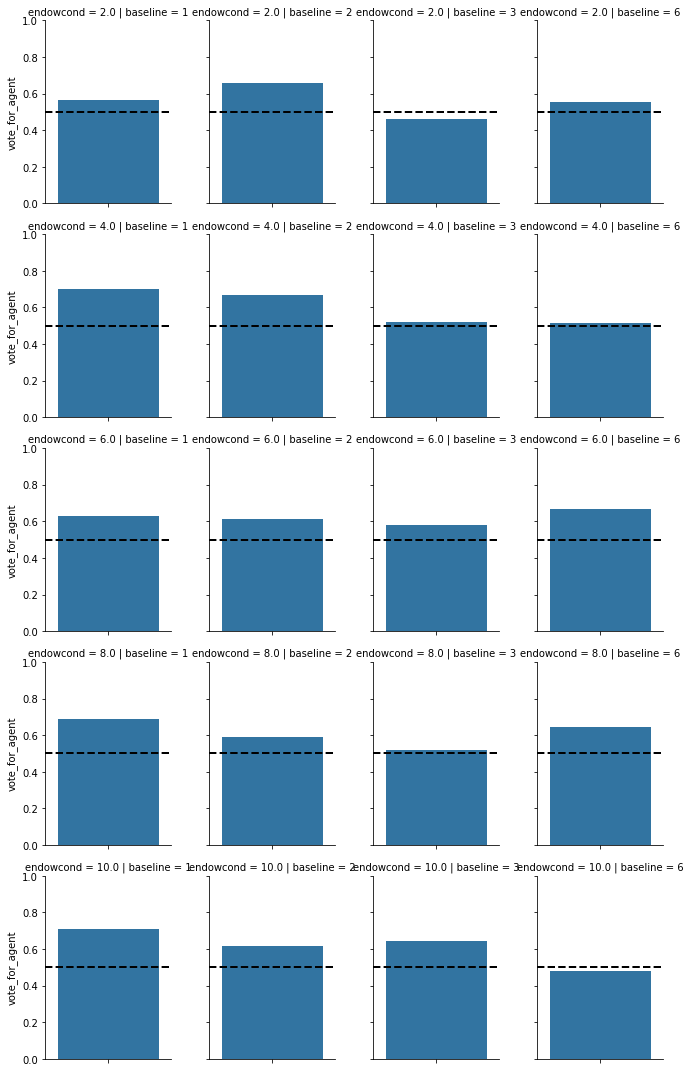

In [ ]:
#@markdown
facet_grid = sns.catplot(
    data=players_exp2[players_exp2.real & players_exp2.vote_cast],
    y='vote_for_agent',
    col='baseline',
    row='endowcond',
    kind='bar',
    ci=None,
    height=3,
    aspect=.8,
)
_ = facet_grid.set(ylim=(0, 1))
for ax in facet_grid.axes.flatten():
  ax.axhline(.5, ls='--', linewidth=2, color='black')

In [ ]:
#@markdown
baseline_names = ['Strict egalitarian', 'Libertarian', 'Liberal egalitarian', 'Rational']
filtered_df = players_exp2[players_exp2.real & players_exp2.vote_cast]
for baseline, baseline_name in zip([1, 2, 3, 6], baseline_names):
  for endowcond in [2., 4., 6., 8., 10.]:
    vote_vector = filtered_df[(
        filtered_df.baseline == baseline) & (
            filtered_df.endowcond == endowcond)]['vote_for_agent'].to_numpy()
    mean_vote = np.mean(vote_vector)
    p = scipy.stats.binom_test(x=np.sum(vote_vector), n=len(vote_vector))
    print(
        f'baseline: {baseline_name};'
        f'Endowment condition:{endowcond};'
        f'Votes for agent: {np.sum(vote_vector)}/{len(vote_vector)},'
        f'{np.round(mean_vote*100, decimals=2)}%, p={np.round(p, decimals=3)}')

baseline: Strict egalitarian; Endowment condition:2.0; Votes for agent: 84/148, 56.76%, p=0.118
baseline: Strict egalitarian; Endowment condition:4.0; Votes for agent: 121/172, 70.35%, p=0.0
baseline: Strict egalitarian; Endowment condition:6.0; Votes for agent: 93/148, 62.84%, p=0.002
baseline: Strict egalitarian; Endowment condition:8.0; Votes for agent: 99/144, 68.75%, p=0.0
baseline: Strict egalitarian; Endowment condition:10.0; Votes for agent: 116/164, 70.73%, p=0.0
baseline: Libertarian; Endowment condition:2.0; Votes for agent: 92/140, 65.71%, p=0.0
baseline: Libertarian; Endowment condition:4.0; Votes for agent: 96/144, 66.67%, p=0.0
baseline: Libertarian; Endowment condition:6.0; Votes for agent: 91/148, 61.49%, p=0.006
baseline: Libertarian; Endowment condition:8.0; Votes for agent: 92/156, 58.97%, p=0.03
baseline: Libertarian; Endowment condition:10.0; Votes for agent: 79/128, 61.72%, p=0.01
baseline: Liberal egalitarian; Endowment condition:2.0; Votes for agent: 162/352, 4

#### **Figure 3A**

> *‘Beach plots’: In simulation with virtual players, revenue share allocated to head player as a function of contribution (relative to endowment) of head vs. tail player. Warmer (colder) colors indicate more funds redistributed to head (tail) player.*

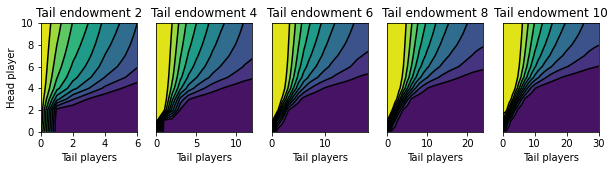

In [ ]:
#@markdown HCRM 
_ = make_beach_figure(hcrm_beach)

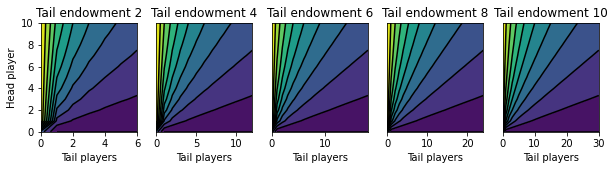

In [ ]:
#@markdown Liberal egalitarian
_ = make_beach_figure(liberal_egalitarian_beach)

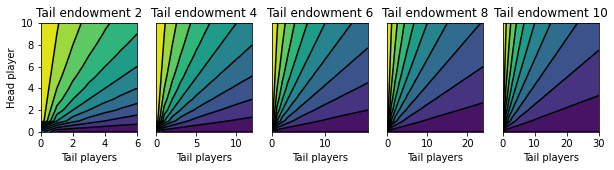

In [ ]:
#@markdown Libertarian
_ = make_beach_figure(libertarian_beach)

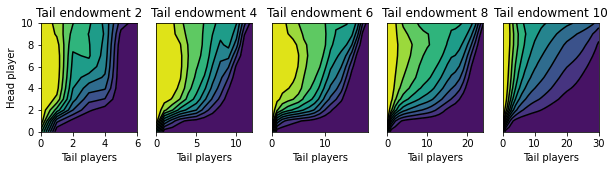

In [ ]:
#@title
#@markdown Rational
_ = make_beach_figure(rational_beach)

#### **Figure 3C**

> *Empirically observed relationship between contributions and payouts for each mechanism and endowment condition.*

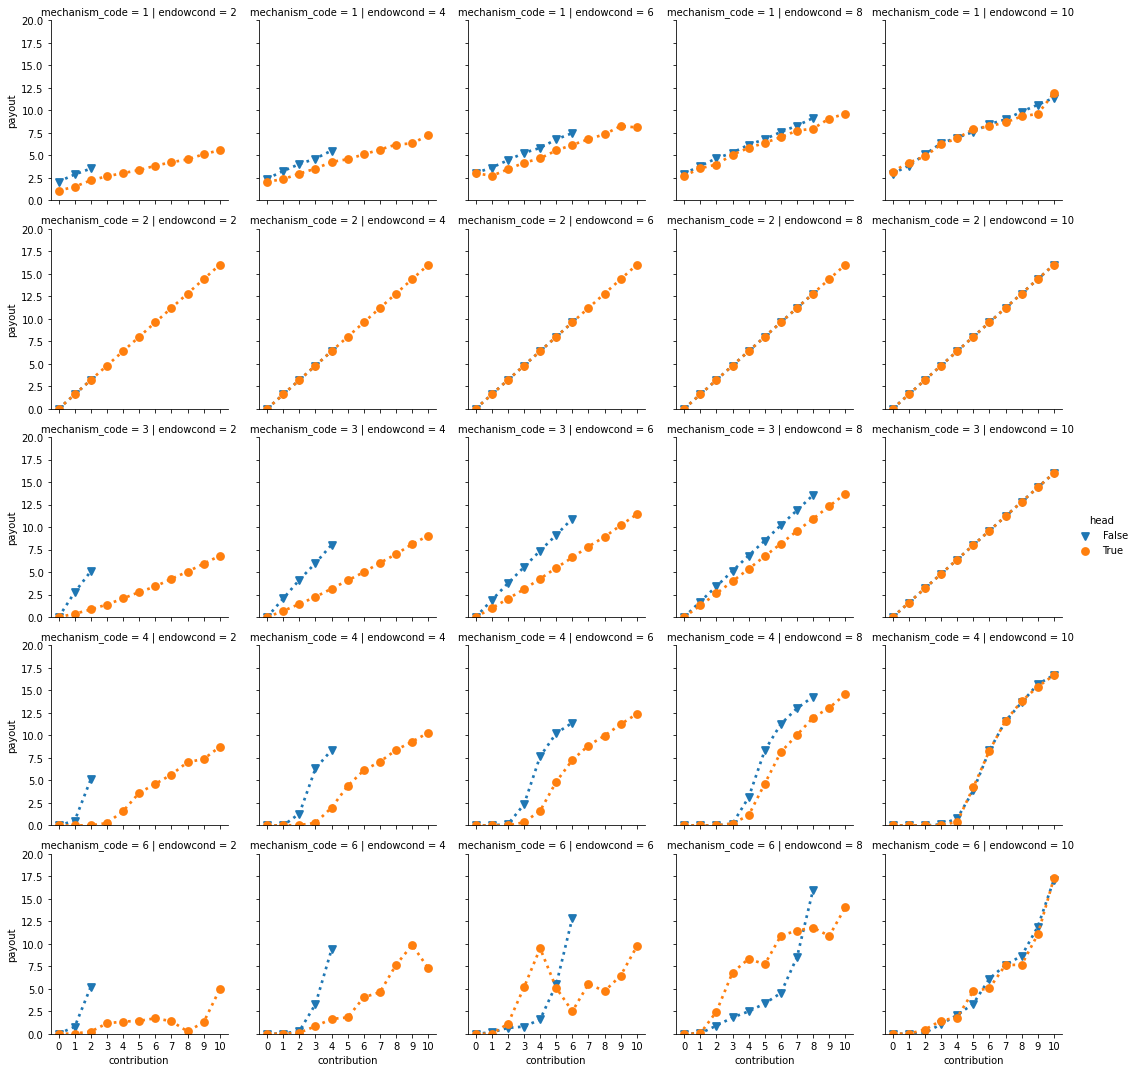

In [ ]:
#@title
facet_grid = sns.catplot(
    data=data_exp2[data_exp2.baseline != 5],
    x='contribution',
    y='payout',
    hue='head',
    col='endowcond',
    row='mechanism_code',
    kind='point',
    ci=None,
    linestyles=['dotted', 'dotted'],
    markers=['v', 'o'],
    height=3,
    aspect=1,
)
_ = facet_grid.set(ylim=(0, 20))